## 使用資料集
本次資料集使用科技政策研究與資訊中心中，科技大擂台競賽的第一輪的測試資料集：
https://scidm.nchc.org.tw/dataset/grandchallenge

語音資料集中包含了文章、問題與選項的音檔以及對應的文字資料，
本次僅針對**文章的部分進行轉換**

| 資料屬性 | 描述                                |
| -------- | ----------------------------------- |
| 音檔數量 | 1297 個                             |
| 音檔格式 | .wav                                |
| 總大小   | 1.69GB                              |
| 平均大小 | 1.3MB                               |
| 音檔長度 | 長度不一，大部分音檔約在10~30秒之間 |

setup dataset

# 語音檔案轉為文字

In [14]:
import speech_recognition as sr

r = sr.Recognizer()
def recoginze_wav_file(wav_file):
    """
    wav_file: file path to the .wav file
    """
    try:
        with sr.WavFile(wav_file) as source:
            audio = r.record(source)
        s = r.recognize_google(audio, language="zh-TW")
        return s
    except:
        return None

In [ ]:
# 辨識目錄下的所有檔案
import os
wav_path = os.getcwd()
wav_list = [x for x in os.listdir(wav_path) if x.endswith(".wav")]

result = []
for wav_file in wav_list:
    print(wav_file)
    wav_file = os.path.join(wav_path, wav_file)
    s = recoginze_wav_file(wav_file)
    result.append(s)

In [5]:
# 計算 WER
import nltk
def calculate_WER(s1, s2):
    # 先去除標點符號
    s1 = re.sub("[，,。、「」；《》\n 『』（）、〈〉()？!！?\[\]]", "", s1)
    s2 = re.sub("[，,。、「」；《》\n 『』（）、〈〉()？!！?\[\]]", "", s2)
    S_D_I = nltk.edit_distance(s1, s2)
    WER = S_D_I / max(len(s1), len(s2))
    return WER

In [7]:
# 檢視語音辨識的辨識率
import pandas as pd
import numpy as np
import re
# 讀取labeled text data
dataset = pd.read_excel('../../../文本總整理Beta 2.xlsx', index_col=0)

WERs = []
for s1, s2 in zip(result, dataset['文章']):
    WER = calculate_WER(s1, s2)
    WERs.append(WER)
print("mean", sum(WERs)/len(WERs))
print("std.", np.std(WERs))

mean 0.16846640760026302
std. 0.15404998574692677


# 分句進行語音解析

In [8]:
import pydub
from pydub import AudioSegment
from pydub.playback import play
import time

# 將音檔音量正規化
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

In [16]:
# 分句進行語音解析
result = {}
for filename in wav_list:
    # print(filename)
    wav_file = os.path.join(wav_path, filename)
    # 讀取音檔
    audio = AudioSegment.from_wav(wav_file)
    # 將所有音檔的音量正規化為-20db
    audio = match_target_amplitude(audio, -20)
    # 根據音檔中的停頓進行斷句
    audio_seg = pydub.silence.split_on_silence(audio, min_silence_len=400, silence_thresh=-35, keep_silence=200 )

    sentences = []
    audio = ""
    for seg in audio_seg:
        seg.export("temp.wav", format = 'wav') # 輸出音檔
        text = recoginze_wav_file("temp.wav")
        if text is not None:
            sentences.append(text)
    result[filename] = {"sentences": sentences, "dialog": " ".join(sentences)}
result["A0000001.wav"]

{'sentences': ['明年元旦起',
  '交通部新規定',
  '汽車輪胎胎紋深度',
  '將納入定期檢驗項目之一',
  '一旦深度未達1.6公里',
  '吃一個月內沒換胎',
  '將會被吊銷牌照',
  '民眾除了定期檢驗胎紋',
  '也可以自己用10元硬幣檢測',
  '只要看得見國父像衣領下緣',
  '表示該換輪胎了'],
 'dialog': '明年元旦起 交通部新規定 汽車輪胎胎紋深度 將納入定期檢驗項目之一 一旦深度未達1.6公里 吃一個月內沒換胎 將會被吊銷牌照 民眾除了定期檢驗胎紋 也可以自己用10元硬幣檢測 只要看得見國父像衣領下緣 表示該換輪胎了'}

# 辨識說話者

In [36]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav

# 提取語音特征
def get_feature(filepath):
    try:
        if os.path.exists(filepath):
            (rate,sig) = wav.read(filepath)
            mfcc_feat = mfcc(sig,rate)
            return mfcc_feat.mean(0) # 取平均壓縮成一個維度
        else:
            return None
    except:
        return None

In [23]:
# 提取每個音檔的第一句話
first_sent_path = os.path.join(wav_path, "first_sent")
if not os.path.exists(first_sent_path):
    os.makedirs(first_sent_path)
    
for filename in wav_list:
    wav_file = os.path.join(wav_path, filename)
    audio = AudioSegment.from_wav(wav_file)
    audio = match_target_amplitude(audio, -20)
    audio_seg = pydub.silence.split_on_silence(audio, min_silence_len=400, silence_thresh=-35, keep_silence=200 )    
    audio_seg[0].export(os.path.join(first_sent_path, "%s_1.wav"% filename.replace(".wav", "")), format = 'wav')

In [52]:
# 提取每個音檔說話者的特征
features = []
for f in wav_list:
    filename = "%s_1.wav" % str(f.replace(".wav", ""))
    feature = get_feature(os.path.join(first_sent_path, filename))
    if feature is not None:
        features.append(feature)

audio_list = pd.concat([pd.DataFrame({"filename": wav_list}), pd.DataFrame(features)], axis=1)
audio_list = audio_list.dropna()
audio_list.head()

,filename,0,1,2,3,4,5,6,7,8,9,10,11,12
0,A0000001.wav,18.096094,-11.892756,-2.123056,16.582659,-5.174572,-27.215824,-0.023904,-9.906385,-7.698156,-11.100230,-8.061810,-2.851566,-8.326654
1,A0000002.wav,18.696538,-10.464451,2.721150,0.744617,-10.223856,-19.417401,4.360140,-7.797048,-7.806503,-1.098990,-12.249830,-1.477440,-8.980457
2,A0000003.wav,18.475559,-10.528024,-7.713499,10.711310,-4.404238,-19.428474,-8.818047,-12.834811,0.269436,-3.038884,-13.272127,-3.002175,-7.597810
3,A0000004.wav,17.497397,-5.098735,-7.346540,-12.139512,-18.185258,-11.821901,21.524810,-10.982321,-10.478891,-2.851431,2.180368,-2.597815,-14.434911
4,A0000005.wav,18.431359,-6.033435,-6.256061,-3.706430,-6.607135,-17.909773,3.574817,-5.803147,-3.445956,-5.670474,-2.274126,-2.903178,-10.247881


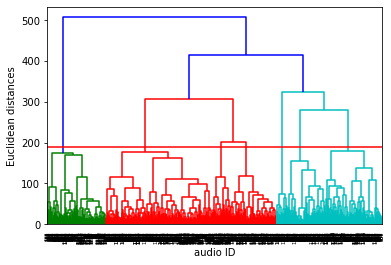

In [53]:
# 進行階層式分群
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(audio_list[audio_list.columns[1:]], method  = "ward"))
plt.xlabel('audio ID')
plt.ylabel('Euclidean distances')
plt.axhline(y=190, color='r', linestyle='-')
plt.show()

In [54]:
# 觀察分佈，大致可以分為6群
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(audio_list[audio_list.columns[1:]])

audio_list = pd.concat([pd.DataFrame({"speaker":y_hc}), audio_list], axis=1)
audio_list

,speaker,filename,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,A0000001.wav,18.096094,-11.892756,-2.123056,16.582659,-5.174572,-27.215824,-0.023904,-9.906385,-7.698156,-11.100230,-8.061810,-2.851566,-8.326654
1,1,A0000002.wav,18.696538,-10.464451,2.721150,0.744617,-10.223856,-19.417401,4.360140,-7.797048,-7.806503,-1.098990,-12.249830,-1.477440,-8.980457
2,0,A0000003.wav,18.475559,-10.528024,-7.713499,10.711310,-4.404238,-19.428474,-8.818047,-12.834811,0.269436,-3.038884,-13.272127,-3.002175,-7.597810
3,0,A0000004.wav,17.497397,-5.098735,-7.346540,-12.139512,-18.185258,-11.821901,21.524810,-10.982321,-10.478891,-2.851431,2.180368,-2.597815,-14.434911
4,0,A0000005.wav,18.431359,-6.033435,-6.256061,-3.706430,-6.607135,-17.909773,3.574817,-5.803147,-3.445956,-5.670474,-2.274126,-2.903178,-10.247881
5,0,A0000006.wav,17.722297,-7.695429,2.872580,15.747067,-4.892952,-29.626357,-1.358373,-13.705101,-11.191271,-12.720838,-11.169683,0.049837,-6.534637
6,0,A0000007.wav,18.367665,-5.468637,-7.798134,-5.806951,-4.573297,-11.347586,1.909552,-16.248558,-0.882392,-1.870088,-1.940898,-9.195962,-14.126155
7,0,A0000008.wav,18.240835,-5.653695,-8.281065,10.043752,-12.838551,-23.847041,3.768808,-13.152516,-2.359709,-5.628101,-5.383947,-4.896779,-7.090729
8,0,A0000009.wav,18.111303,-5.864101,-7.684641,2.077554,-13.695707,-19.854759,8.176607,-16.185134,-3.158137,-11.476022,-4.430611,-4.126050,-7.762215
9,0,A0000010.wav,18.998817,-12.052691,-3.525797,13.015011,-6.118576,-32.856784,2.783771,-18.743879,-0.820724,-4.680548,-10.981273,-0.142455,-7.833394
